In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

import shap

from xgboost import XGBClassifier,plot_importance
import lightgbm
#!pip install scikit-learn==0.23.2 --user
from imblearn.over_sampling import SMOTE



Using TensorFlow backend.


n_folds = 5
folds =  StratifiedKFold(n_folds)

In [2]:
zoe = pd.read_excel('Αντίγραφο του Αντίγραφο του Zoe central.xlsx')

In [3]:
zoe['id'] = zoe['Slide ID']+'_'+zoe['Well'].astype(str)

In [4]:
zoe['transfer'].value_counts()

transfer      3265
transfer1      160
transfer2      147
Transfer        73
Transfer1       25
Transfer2       22
transfer3       21
Transfer3       10
transfer         3
transfer2        1
Transfer5        1
Transfer4        1
Name: transfer, dtype: int64

In [5]:
graded_by_zoe = zoe.loc[zoe['Grade at approx. 65h - Zoe'].notna()]

In [6]:
graded_by_steve = zoe.loc[zoe['Morphological Grade - Value'].notna()]

In [7]:
graded_by_chrysa = zoe.loc[zoe['Grade at approx. 65h - Chrysa'].notna()]

In [8]:
graded_by_chrysa.shape[0]+graded_by_zoe.shape[0]+graded_by_steve.shape[0]

18318

In [82]:
graded_by_steve

,Slide ID,Patient ID,Well,Birth Year,Birth Month,BMI,Diagnosis,Basal Serum FSH,Patient Comments,Fertilization,...,Pronuclei - Value 1,Pronuclei - Time 2,Pronuclei - Value 2,Pronuclei - Time 3,Pronuclei - Value 3,Pronuclei - Time 4,Pronuclei - Value 4,Pronuclei - Time 5,Pronuclei - Value 5,id
25,D2011.06.01_S0060_I149,35309,2,1969.0,6.0,0.0,NaN,0.0,NaN,40694.61111,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2011.06.01_S0060_I149_2
26,D2011.06.01_S0060_I149,35309,3,1969.0,6.0,0.0,NaN,0.0,NaN,40694.61111,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2011.06.01_S0060_I149_3
27,D2011.06.01_S0060_I149,35309,4,1969.0,6.0,0.0,NaN,0.0,NaN,40694.61111,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2011.06.01_S0060_I149_4
29,D2011.06.01_S0060_I149,35309,6,1969.0,6.0,0.0,NaN,0.0,NaN,40694.61111,...,2.0,65.331918,2.0,NaN,NaN,NaN,NaN,NaN,NaN,D2011.06.01_S0060_I149_6
31,D2011.06.01_S0060_I149,35309,8,1969.0,6.0,0.0,NaN,0.0,NaN,40694.61111,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2011.06.01_S0060_I149_8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26523,D2020.09.16_S02296_I0149_D,493410,7,1982.0,6.0,NaN,NaN,NaN,NaN,44090.57639,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2020.09.16_S02296_I0149_D_7
26524,D2020.09.16_S02296_I0149_D,493410,8,1982.0,6.0,NaN,NaN,NaN,NaN,44090.57639,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2020.09.16_S02296_I0149_D_8
26529,D2020.09.18_S02297_I0149_D,512316,1,NaN,NaN,NaN,NaN,NaN,NaN,44091.57639,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2020.09.18_S02297_I0149_D_1
26530,D2020.09.18_S02297_I0149_D,512316,2,NaN,NaN,NaN,NaN,NaN,NaN,44091.57639,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D2020.09.18_S02297_I0149_D_2


In [10]:
concated = pd.concat([graded_by_zoe, graded_by_steve, graded_by_chrysa])

In [11]:
concated = concated.drop_duplicates('id')#[cols].info()

In [12]:
concated.shape

(12516, 192)

In [13]:
concated['grade'] = 0

concated.loc[concated['Morphological Grade - Value'].notna(),'grade'] = concated.\
                                    loc[concated['Morphological Grade - Value'].notna(),'Morphological Grade - Value']

concated.loc[concated['Grade at approx. 65h - Chrysa'].notna(),'grade'] = concated.\
                                    loc[concated['Grade at approx. 65h - Chrysa'].notna(),'Grade at approx. 65h - Chrysa']

concated.loc[concated['Grade at approx. 65h - Zoe'].notna(),'grade'] = concated.\
                                    loc[concated['Grade at approx. 65h - Zoe'].notna(),'Grade at approx. 65h - Zoe']

grade_idx = pd.to_numeric(concated['grade'], errors='coerce').notna()

concated = concated.loc[grade_idx]

In [14]:
def kseska(x):
    try:
        np.float(x['Morphological Grade - Value'])
        return x
    except: pass


In [238]:
#t = zoe.apply(kseska,axis=1)
t = concated.copy()

In [239]:
def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=32,
      lw=0.5, cbar=False, figsize=[12,12], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sns.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 30)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 30)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()

In [240]:
embryo_count = t.groupby('Patient ID').apply(lambda x: x.shape[0]).reset_index()

In [241]:
embryo_count.columns = ['Patient ID', 'embryo_count']

In [242]:
t = pd.merge(t, embryo_count, on='Patient ID', how='left')

In [243]:
t['total_time'] = t['End Time'] -t['Start Time']

In [244]:
avg_time =  t.groupby('Patient ID').apply(lambda x: x[x['total_time']<2.5].total_time.mean()).reset_index()

In [245]:
#std_time =  t.groupby('Patient ID').apply(lambda x: x[x['total_time']<2.5].total_time.std()).reset_index()

In [246]:
#t[t['total_time']<2.5]['End Time']

In [247]:
avg_time.columns = ['Patient ID', 'avg_time']

In [248]:
more_time =  t.groupby('Patient ID').apply(lambda x: x[x['total_time']<2.5].total_time.mean()).reset_index()

In [249]:
t = pd.merge(t, avg_time, on='Patient ID', how='left')

In [250]:
t['Grade at approx. 65h - Zoe'].value_counts()

2.0    1855
3.0     914
1.5     903
2.5     730
1.0     498
3.5     407
4.0     193
Name: Grade at approx. 65h - Zoe, dtype: int64

In [251]:
concated['Decision'].value_counts()

Transfer                  3120
Freeze                    2127
Not decided               1762
Avoid                      938
Frozen Embryo Transfer     386
Name: Decision, dtype: int64

In [252]:
for c in t.columns:
    print(c)

Slide ID
Patient ID
Well
Birth Year
Birth Month
BMI
Diagnosis
Basal Serum FSH
Patient Comments
Fertilization
Age
Fertilization Method
Fertilization Comment
Transfer Validation
Decision
Embryo Description
Embryo ID
Treatment ID
Sibling Embryos
Medication Protocol
Medication Trigger
Medication Brand
Medication FSH Dose
LH Supplement
Medication Comment
Oocyte History
Oocyte Source
Oocytes Aspirated
Media Type
Media Brand 1
Media Brand 2
Media Change
Media Comment
Slide Description
Start Time
End Time
Runs
Annotation QC
Annotation QC Date
Annotation QC Status
Clinical Slide Type
Annotation QC Comment
Instrument QC
Instrument QC Date
Instrument QC Decision
Instrument QC Comment
tPB2
tPNa
tPNf
t2
t3
t4
t5
t6
t7
t8
t9
tSC
tM
tSB
tB
tEB
tHB
tDead
Transferred
Dynamic Score - Time
Dynamic Score - Value
Morphological Grade - Time
Morphological Grade - Value
Slide ID copy
Patient ID copy
Well copy
Grade at approx. 65h - Zoe
Grade at approx. 65h - Chrysa
Pronuclei - Value 1 copy
pgs
transfer
unique

In [253]:
results = t[['Slide ID', 'Well','HCG Test','Gestational Sacs','Fetal Heart Beat','Live Born', 'Morphological Grade - Value']].dropna(thresh=4)

In [254]:
concated['Day5 Grade'].value_counts()

ARR    415
4AA    113
3BB     95
4BB     79
4AB     37
2BB     33
3AA     33
5BB     30
2CC     29
5AA     24
3AB     22
3BC     22
3CC     22
1CC     19
5AB     12
3CB     10
DEG     10
4BC      9
4BA      7
2AA      6
5BA      6
4CC      6
4CB      3
2AB      3
1BB      3
2BC      2
5BC      2
4AC      2
4CA      1
         1
5CB      1
1CB      1
5CC      1
5AC      1
3BA      1
2CB      1
Name: Day5 Grade, dtype: int64

In [255]:
results['HCG Test'].value_counts()

Positive    1287
Negative    1023
positive     107
Unknown       48
negative      26
0              5
no et          1
Name: HCG Test, dtype: int64

In [256]:
results['HCG Test'] = results['HCG Test'].replace('Positive', 1)
results['HCG Test'] = results['HCG Test'].replace('positive', 1)
results['HCG Test'] = results['HCG Test'].replace('Negative', 0)
results['HCG Test'] = results['HCG Test'].replace('negative', 0)
results['HCG Test'] = results['HCG Test'].replace('Unknown', 0)
results['HCG Test'] = results['HCG Test'].replace('no et', 0)

In [257]:
results.to_csv('embryo_hcg_test.csv', index=False)

In [258]:
cols = ['Patient ID',
                 'Age',
                 'tPNf',
                 't2',
                 't3',
                 't4',
                 't5',
                 't6',
                    'Blastomere Size - Time 1',
                 'Blastomere Size - Value 1',
                'Pronuclei - Time 1',
                'Multi Nucleation - Value 1',
                'Multi Nucleation - Time 1',
                 'grade']
#test_df = t[cols]

In [261]:
t.loc[:,'tPNf':'t6'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12383 entries, 0 to 12382
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tPNf    12114 non-null  float64
 1   t2      12114 non-null  float64
 2   t3      12114 non-null  float64
 3   t4      12114 non-null  float64
 4   t5      12114 non-null  float64
 5   t6      12114 non-null  float64
dtypes: float64(6)
memory usage: 677.2 KB


SyntaxError: invalid syntax (<ipython-input-267-215cbcafed9e>, line 1)

In [262]:
t

,Slide ID,Patient ID,Well,Birth Year,Birth Month,BMI,Diagnosis,Basal Serum FSH,Patient Comments,Fertilization,...,Pronuclei - Value 3,Pronuclei - Time 4,Pronuclei - Value 4,Pronuclei - Time 5,Pronuclei - Value 5,id,grade,embryo_count,total_time,avg_time
0,D2011.06.29_S0078_I149,477687,2,1977.0,9.0,25.0,NaN,0.0,PGS,40723.56944,...,NaN,NaN,NaN,NaN,NaN,D2011.06.29_S0078_I149_2,2,5,2.74852,NaN
1,D2011.06.29_S0078_I149,477687,5,1977.0,9.0,25.0,NaN,0.0,PGS,40723.56944,...,NaN,NaN,NaN,NaN,NaN,D2011.06.29_S0078_I149_5,1,5,2.74852,NaN
2,D2011.06.29_S0079_I149,475984,1,1976.0,2.0,0.0,NaN,0.0,PGS MULTIPLE FAILURES & 2X BIOCHEMICALS,40723.56944,...,NaN,NaN,NaN,NaN,NaN,D2011.06.29_S0079_I149_1,1,6,2.73806,NaN
3,D2011.06.29_S0079_I149,475984,3,1976.0,2.0,0.0,NaN,0.0,PGS MULTIPLE FAILURES & 2X BIOCHEMICALS,40723.56944,...,NaN,NaN,NaN,NaN,NaN,D2011.06.29_S0079_I149_3,1,6,2.73806,NaN
4,D2011.10.06_S0094_I149,470376,2,1977.0,5.0,21.0,Unexplained Infertility,0.0,PGS - HCG 255\r\nPREVIOUS MISC 5/40 (2011) BL...,40822.54861,...,NaN,NaN,NaN,NaN,NaN,D2011.10.06_S0094_I149_2,2,9,2.78709,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12378,D2020.03.02_S02176_I0149_D,MIX 020320,3,NaN,NaN,NaN,NaN,NaN,NaN,43892.50000,...,NaN,NaN,NaN,NaN,NaN,D2020.03.02_S02176_I0149_D_3,4,5,2.95274,NaN
12379,D2020.03.02_S02176_I0149_D,MIX 020320,6,NaN,NaN,NaN,NaN,NaN,NaN,43892.50000,...,NaN,NaN,NaN,NaN,NaN,D2020.03.02_S02176_I0149_D_6,3,5,2.95274,NaN
12380,D2020.04.06_S02201_I0149_D,060420 NC,12,NaN,NaN,NaN,NaN,NaN,NaN,43927.59722,...,NaN,NaN,NaN,NaN,NaN,D2020.04.06_S02201_I0149_D_12,3,3,2.83348,NaN
12381,D2020.05.16_S02237_I0149_D,160520 B,3,NaN,NaN,NaN,NaN,NaN,NaN,43967.61111,...,NaN,NaN,NaN,NaN,NaN,D2020.05.16_S02237_I0149_D_3,2.5,7,2.73342,NaN


In [260]:
#imp_mean = IterativeImputer(random_state=0, sample_posterior=True)
t.loc[:,'tPNf':'t6'] = t.loc[:,'tPNf':'t6'].fillna(method='ffill',axis=1) 
t.loc[:,'tPNf':'t6'] = t.loc[:,'tPNf':'t6'].fillna(method='bfill',axis=1) 
#results_with_bad.loc[:,'tPNf':'t6'] = imp_mean.fit_transform(results_with_bad.loc[:,'tPNf':'t6'])

In [268]:
t = t.loc[t.loc[:,'tPNf'].notna()]

In [269]:
t = t.fillna(value=t.mean())

In [270]:
def dt_cols(df):
    lst = df.columns
    if len(lst)==1:
        pass
    else:
        start = lst[0]
        lst = lst[1:]
        col_names = [item+'-'+start for item in lst]
        temp = df.loc[:,lst].T.subtract(df.loc[:,start].T).T
        temp.columns = col_names
        dts.append(temp)
        dt_cols(df[lst])

In [271]:
test_df = t[cols]

In [272]:
dts = []
dt_cols(test_df.loc[:,'tPNf':'t6'])
dt_df = pd.concat(dts, axis=1)
dt_df.dropna(axis=1, how='all', inplace=True)
#for f in dt_df.columns:
dt_df[dt_df<0] = 0
#scaled_data = scale(dt_df, scale_method)

#dt_df.loc[:,:] = scale(dt_df, scale_method)
#df_new.loc[:,'tPNf':'tM'] = scale(df_new.loc[:,'tPNf':'tM'], scale_method)

test_df = pd.concat([test_df, dt_df], axis=1)

In [273]:
test_df = test_df.drop(test_df[test_df['Blastomere Size - Time 1']<0].index)

In [274]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
#test_df.loc[:,'tPNf':'t6'] = test_df.loc[:,'tPNf':'t6'].fillna(method='ffill')

In [275]:
imp_mean = IterativeImputer(random_state=0, sample_posterior=True)

#test_df.loc[:,'tPNf':'t6'] = imp_mean.fit_transform(test_df.loc[:,'tPNf':'t6'])

In [276]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12114 entries, 0 to 12381
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient ID                  12114 non-null  object 
 1   Age                         12114 non-null  float64
 2   tPNf                        12114 non-null  float64
 3   t2                          12114 non-null  float64
 4   t3                          12114 non-null  float64
 5   t4                          12114 non-null  float64
 6   t5                          12114 non-null  float64
 7   t6                          12114 non-null  float64
 8   Blastomere Size - Time 1    12114 non-null  float64
 9   Blastomere Size - Value 1   10293 non-null  object 
 10  Pronuclei - Time 1          12114 non-null  float64
 11  Multi Nucleation - Value 1  12114 non-null  float64
 12  Multi Nucleation - Time 1   12114 non-null  float64
 13  grade                       121

In [277]:
#zoe_test = test_df[test_df['Grade at approx. 65h - Zoe'].notnull()]
X = test_df.drop(
    ['grade'],
    axis=1
    )

y = test_df['grade']



In [278]:
X.shape

(12114, 28)

In [279]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score

#X.loc[:,'Blastomere Size - Value 1'] = X['Blastomere Size - Value 1'].fillna(value='Even')
enc = LabelEncoder()
#X.loc[:,'Blastomere Size - Value 1'] = enc.fit_transform(X.loc[:,'Blastomere Size - Value 1'].astype(str))

In [280]:
X.loc[:,'Blastomere Size - Value 1'] = X.loc[:,'Blastomere Size - Value 1'].replace('Even',0)
X.loc[:,'Blastomere Size - Value 1'] = X.loc[:,'Blastomere Size - Value 1'].replace('Uneven',1)#.astype(str).value_counts()

In [281]:
X.loc[:,'Blastomere Size - Value 1'].value_counts()

0.0    8392
1.0    1901
Name: Blastomere Size - Value 1, dtype: int64

In [282]:
y = y.astype(float)

In [283]:
y.loc[y<=2.5] = 0
#y.loc[(y>1.5)&(y<=2.5)] = 1
y.loc[y>2.5] = 1

In [284]:
enc = LabelEncoder()
X['Patient ID'] = enc.fit_transform(X['Patient ID'].values.astype(str))

In [285]:
X.shape

(12114, 28)

In [286]:
hyper_params ={'bagging_fraction': 0.4888616113099826,
 'feature_fraction': 0.5390170120982255,
 'learning_rate': 0.13733834596726877,
 'max_bin': 159,
 'max_depth': 49,
 'min_data_in_leaf': 162,
 'min_sum_hessian_in_leaf': 63.14732794308846,
 'num_leaves': 34,
 'subsample': 0.07075367348204263,

 'is_unbalance': True,
 'boost_from_average': False}

In [287]:
from sklearn.preprocessing import LabelEncoder

In [288]:
from sklearn.model_selection import KFold

In [322]:
del X['Patient ID']

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91      1887
         1.0       0.67      0.66      0.66       536

    accuracy                           0.85      2423
   macro avg       0.79      0.78      0.78      2423
weighted avg       0.85      0.85      0.85      2423

acc: 0.8522492777548494
auc:  0.8744384199827571


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89      1721
         1.0       0.79      0.56      0.66       702

    accuracy                           0.83      2423
   macro avg       0.81      0.75      0.77      2423
weighted avg       0.82      0.83      0.82      2423

acc: 0.8291374329343789
auc:  0.8587161111856056


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88      1713
         1.0       0.74      0.64      0.69       710

    accuracy                           0.83      2423
   macro avg       0.80      0.77      0.78      2423
weighted avg       0.82      0.83      0.82      2423

acc: 0.8278992983904251
auc:  0.8685832449454463


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      1797
         1.0       0.80      0.60      0.68       626

    accuracy                           0.86      2423
   macro avg       0.84      0.77      0.80      2423
weighted avg       0.85      0.86      0.85      2423

acc: 0.858027238959967
auc:  0.878662698391533


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      1915
         1.0       0.72      0.65      0.68       507

    accuracy                           0.87      2422
   macro avg       0.81      0.79      0.80      2422
weighted avg       0.87      0.87      0.87      2422

acc: 0.8732452518579686
auc:  0.9025115742528879


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


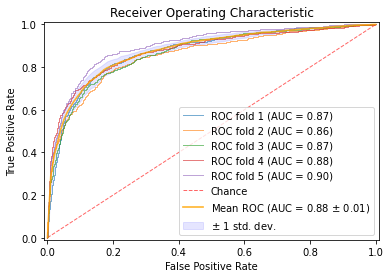

In [323]:
%matplotlib inline
from numpy import interp
from sklearn.metrics import roc_auc_score, roc_curve, \
                f1_score, precision_score, recall_score
NFolds = 5

avg_acc = 0
avg_rec = 0
avg_prc = 0
avg_f1 = 0

blind_preds = 0

confs = []
importances = []

folds = KFold(NFolds)
tprs = []
aucs = []
preds = []
avg_pred = []
avg_auc = 0
metrics = []
#importances = []
fprs__ = []
tprs__ =[]
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
i = 1

shap_values_agg = []

y_preds_whole = np.zeros_like(y.values)#)
for train, test in folds.split(X, y):
    X_train,  y_train = X.iloc[train,:], y.values[train]
    X_test,  y_test = X.iloc[test,:], y.values[test]
    

    clf = lightgbm.LGBMClassifier()
    clf.fit(X_train, y_train)

         #early_stopping_rounds=10)
    #feature_imp = pd.DataFrame(zip(clf.feature_importances_,X.columns), columns=['Value','Feature'])
    #importances.append(feature_imp)
    
    preds1 = clf.predict_proba(X_test)
     #blind_preds += clf.predict_proba(X_blind_test)/NFolds
    preds = np.argmax((preds1), 1)
    
    print(classification_report(y_test, preds))
    print('acc:', accuracy_score(y_test, preds))
    print('auc: ', roc_auc_score(y_test,preds1[:,1]))
    avg_auc += roc_auc_score(y_test,preds)
    confs.append(confusion_matrix(y_test, preds))
    viz = plot_roc_curve(clf, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.6, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    i += 1
    from sklearn.metrics import roc_auc_score
     #blind_predictions = np.argmax(blind_preds, 1)
     #test_auc = roc_auc_score(y_blind_test, blind_predictions, average='macro')
     #print(test_auc)
    explainer = shap.TreeExplainer(clf, feature_perturbation = "tree_path_dependent")
    shap_values = explainer.shap_values(X_test)
    shap_values_agg.append(shap_values)
    #shap.summary_plot(shap_values[1], X_test)
    #plt.show()
ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
            label='Chance', alpha=.6)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='orange',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=1.7, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.1,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01, 1.01], ylim=[-0.01, 1.01],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()    


In [290]:
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

In [291]:
mean_fpr = np.linspace(0, 1, 100)

In [292]:
import pickle

In [293]:
pickle.dump((mean_tpr, mean_fpr),open('roc_curve_day3_grade.pkl', 'wb'))

In [294]:
#tp_blasto = pickle.load(open('roc_curve_blasto35.pkl', 'rb'))

In [295]:
filename = 'morpho_grade_clf.pkl'
pickle.dump(clf, open(filename, 'wb'))

filename = 'morpho_grade_features.pkl'
pickle.dump(list(X.columns), open(filename, 'wb'))


In [296]:
fake_preds = [0 for _ in range(len(y_test))]

In [297]:
print(roc_auc_score(y_test, fake_preds))

0.5


In [298]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 7118, 1.0: 2574}

In [299]:
fig.savefig('myimage.png', format='png', dpi=1000)

In [324]:
mean_auc

0.8762344055047386

In [301]:
np.round(avg_prc,3)

0

In [302]:
temp = [m['macro avg'] for m in metrics]
precision = [m['precision'] for m in temp]
recall = [m['recall'] for m in temp]
f1 = [m['f1-score'] for m in temp]

In [303]:
f'Acc: {np.round(avg_acc,2)}, F1: {np.round(avg_f1,3)}, Recall: {np.round(avg_rec,3)}, Precision: {np.round(avg_prc,3)}'

'Acc: 0, F1: 0, Recall: 0, Precision: 0'

In [214]:
'Acc: 0.85, F1: 0.813, Recall: 0.8, Precision: 0.838'

'Acc: 0.85, F1: 0.813, Recall: 0.8, Precision: 0.838'

In [215]:
blind_predictions = np.argmax(blind_preds, 1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [216]:
viz = plot_roc_curve(clf, X_blind_test, y_blind_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.6, lw=1, ax=ax)
mean_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
#interp_tpr[0] = 0.0
mean_fpr = np.linspace(0, 1, 100)

NameError: name 'X_blind_test' is not defined

In [217]:
mean_auc = auc(mean_fpr, mean_tpr)

In [304]:
mean_auc

0.8739022114450833

In [219]:
from sklearn.metrics import roc_auc_score
acc=accuracy_score(y_blind_test, blind_predictions)

f1 = f1_score(y_blind_test, blind_predictions, average='macro')
rec = precision_score(y_blind_test, blind_predictions, average='macro')
prc = recall_score(y_blind_test, blind_predictions, average='macro')
auc_blind = roc_auc_score(y_blind_test, blind_predictions, average='macro')

NameError: name 'y_blind_test' is not defined

In [220]:
print(f'Blind Test')
print(f'Acc: {np.round(acc,3)}, F1: {np.round(f1,3)}, Recall: {np.round(rec,3)},\
        Precision: {np.round(prc,3)}, AUC: {np.round(auc_blind, 3)}')
print(confusion_matrix(y_blind_test, blind_predictions))

Blind Test


NameError: name 'acc' is not defined

In [111]:
print(f'Avg 5 folds')
print(f'Acc: {np.round(avg_acc,2)}, F1: {np.round(avg_f1,3)}, \
        Recall: {np.round(avg_rec,3)}, Precision: {np.round(avg_prc,3)}')

Avg 5 folds
Acc: 0.85, F1: 0.813,         Recall: 0.8, Precision: 0.838


In [114]:
def get_new_fig(fn, figsize=[20,20]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['Sum'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
    
def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del

In [91]:
%matplotlib inline
from matplotlib.collections import QuadMesh
import matplotlib.font_manager as fm
conf = pd.DataFrame(sum(confs))
pretty_plot_confusion_matrix(conf.T)

NameError: name 'insert_totals' is not defined

In [2]:
%matplotlib inline
sns.heatmap(sum(confs),annot=True, annot_kws = {'fontsize':15}, cmap=plt.cm.Oranges, 
            fmt="d");

NameError: name 'sns' is not defined

In [59]:
import shap

In [167]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12375 entries, 0 to 12382
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient ID                  12375 non-null  int64  
 1   Age                         12375 non-null  float64
 2   tPNf                        12375 non-null  float64
 3   t2                          12375 non-null  float64
 4   t3                          12375 non-null  float64
 5   t4                          12375 non-null  float64
 6   t5                          12375 non-null  float64
 7   t6                          12375 non-null  float64
 8   Blastomere Size - Time 1    12375 non-null  float64
 9   Blastomere Size - Value 1   10294 non-null  float64
 10  Pronuclei - Time 1          12375 non-null  float64
 11  Multi Nucleation - Value 1  12375 non-null  float64
 12  Multi Nucleation - Time 1   12375 non-null  float64
 13  t2-tPNf                     123

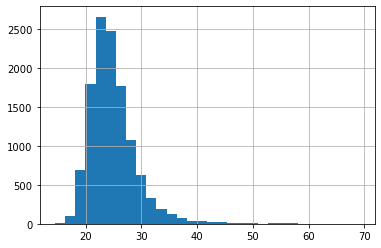

In [325]:
X.tPNf.hist(bins=30)

In [381]:

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
#clf = lightgbm.LGBMClassifier(**hyper_params, use_missing=False)
X_shap_train, X_shap_test, y_shap_train, y_shap_test = train_test_split(X, y)
clf.fit(X_shap_train, y_shap_train)
explainer = shap.TreeExplainer(clf)
sample = X_shap_train#.sample(1000)
shap_values = explainer.shap_values(sample)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [327]:
def shap_save_to_disk(self):
    print("Saving SHAP to .h5 file...")
    h5_file = self.h5_file
    shap_val_df = pd.DataFrame(self.shap_values) #this step is unnecessary, could just save np arrays directly, but the df have some advantages and I don't mind reconverting upon loading
    shap_feat_df = pd.DataFrame(self.features_shap)
    # define what goes in the first row with "d"
    d = [[self.target, self.name_for_figs, self.shap_expected, self.class_thresh]]
    exp_df = pd.DataFrame(
        d, columns=("target", "name_for_figs", "shap_exp_val", "class_thresh")
    )
    shap_val_df.to_hdf(h5_file, key="shap_values", format="table")
    shap_feat_df.to_hdf(h5_file, key="features_shap", format="table")
    exp_df.to_hdf(h5_file, key="shap_expected_value", format="table")

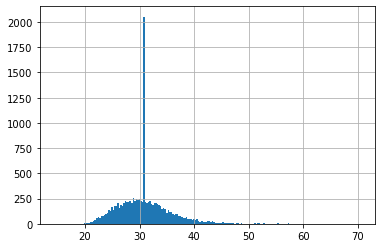

In [328]:

X['Blastomere Size - Time 1'].hist(bins=200)

#X['Multi Nucleation - Time 1'].hist(bins=100)


In [382]:
import pickle
pickle.dump(explainer, open('../embryosense/embryos/trained_models/morpho_shap_explainer.pkl', 'wb'))

In [385]:
import pickle
pickle.dump(clf, open('../embryosense/embryos/trained_models/morpho_clf.pkl', 'wb'))

In [386]:
pickle.dump(X.columns.tolist(), open('../embryosense/embryos/trained_models/morpho_clf_features.pkl', 'wb'))

In [383]:
explainer = pickle.load(open('../embryosense/embryos/trained_models/morpho_shap_explainer.pkl', 'rb'))

In [384]:
shap_values = explainer.shap_values(sample)

In [332]:
%matplotlib inline
#for i in X_train.columns:
#fig, ax = plt.subplots()
i = 'Patient ID'
shap.dependence_plot(i, shap_values[1], sample, show=False, interaction_index=None, alpha = 1, x_jitter=.1)
#plt.savefig(f'dependence_plot{i}.png', format='png', dpi=800)

ValueError: Could not find feature named: Patient ID

In [370]:
y.value_counts()

0.0    9033
1.0    3081
Name: grade, dtype: int64

In [371]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
12375    1.0
12376    0.0
12379    1.0
12380    1.0
12381    0.0
Name: grade, Length: 12114, dtype: float64

In [334]:
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding, Isomap

In [335]:
mnfold  =Isomap()

In [336]:
y_shp = shap_values[1][:,1]


In [337]:
shap_values[1].shape

(9085, 27)

In [338]:
shp_cols = [f+'_shap' for f in X_shap_train.columns]

In [347]:
shap_df = pd.DataFrame(shap_values[1], columns=shp_cols)

In [358]:
shap_df['id'] = np.arange(0, shap_df.shape[0])

In [372]:
shap_df['y'] = y_shap_train.values

In [360]:
X_shap_train['id'] = np.arange(0, X_shap_train.shape[0])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [362]:
shap_df = pd.merge(X_shap_train, shap_df, on='id')

In [373]:
shap_df.to_csv('../embryosense/embryos/data/morpho_shap_values.csv', index=False)

In [341]:
.to_csv('morpho_grade_shap_values.csv', index=False)

SyntaxError: invalid syntax (<ipython-input-341-7515099013de>, line 1)

In [145]:
tmp = np.zeros((y_shp.shape[0],2))

In [152]:
tmp[:,0] = X_shap_train.tPNf.values
tmp[:,1] = shap_values[1][:,2]

In [374]:
tmp

array([[ 2.43846062e+01, -1.49729993e-02],
       [ 2.43846062e+01, -3.10738292e-02],
       [ 2.39907506e+01,  4.14802994e-02],
       ...,
       [ 2.08933378e+01, -3.72577389e-02],
       [ 2.38069439e+01, -7.26653670e-02],
       [ 2.82696814e+01, -1.49506955e-01]])

In [157]:
transformed = mnfold.fit_transform(shap_values[1])

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


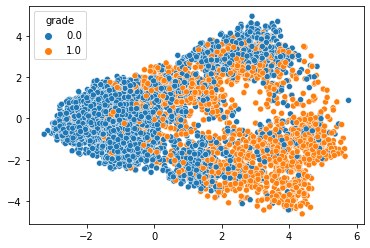

In [161]:
sns.scatterplot(transformed[:,0], transformed[:,1], hue=y_shap_train)

Age


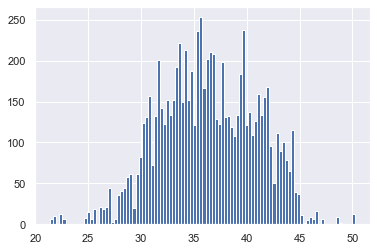

tPNf


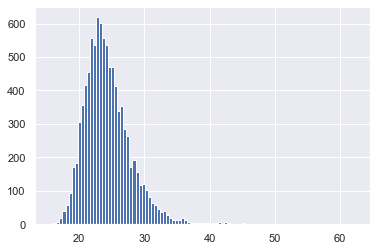

t2


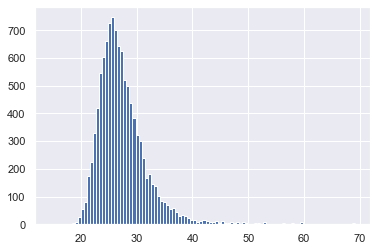

t3


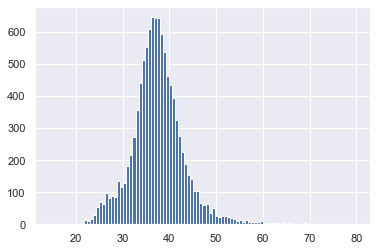

t4


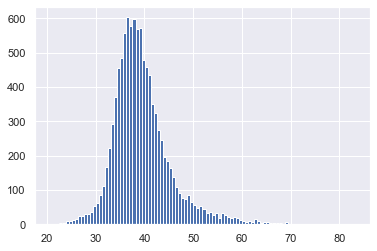

t5


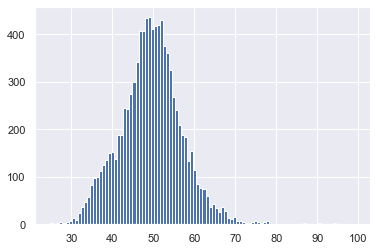

t6


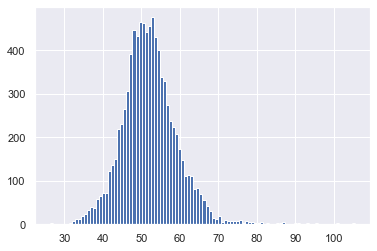

Blastomere Size - Time 1


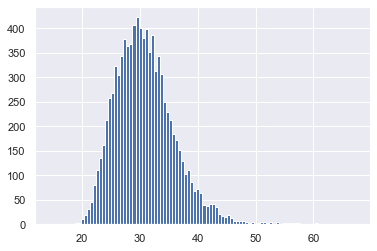

Blastomere Size - Value 1


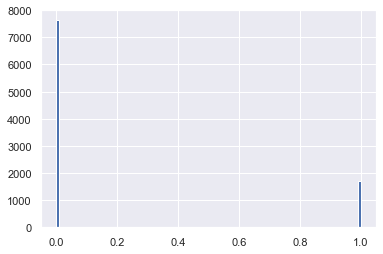

Pronuclei - Time 1


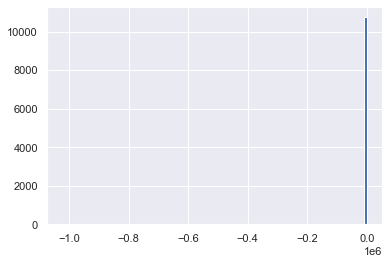

Multi Nucleation - Value 1


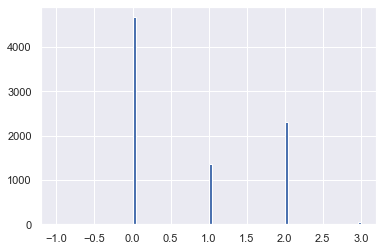

Multi Nucleation - Time 1


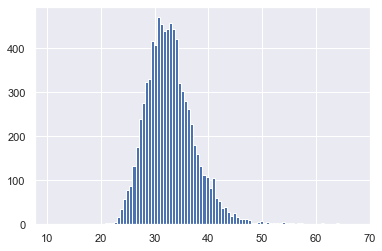

t2-tPNf


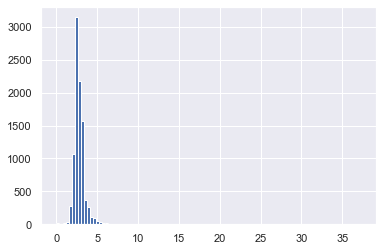

t3-tPNf


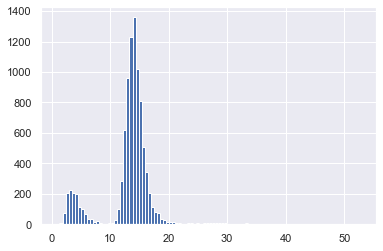

t4-tPNf


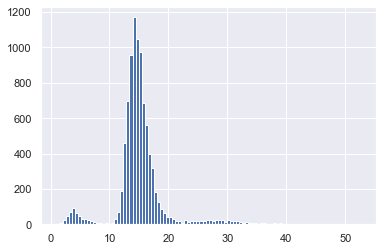

t5-tPNf


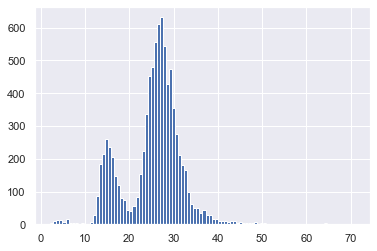

t6-tPNf


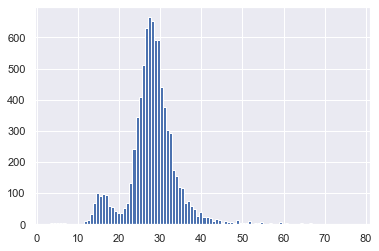

t3-t2


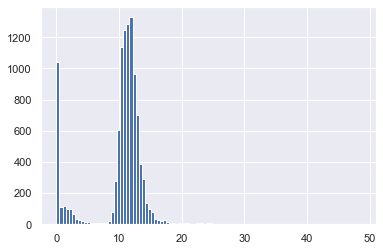

t4-t2


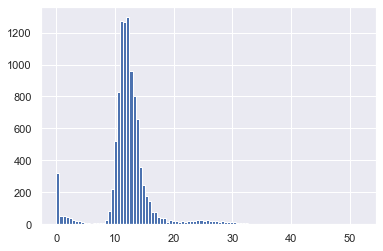

t5-t2


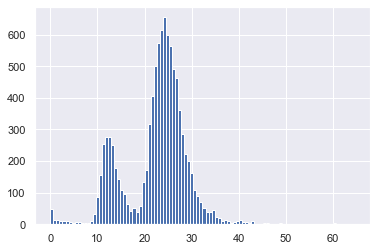

t6-t2


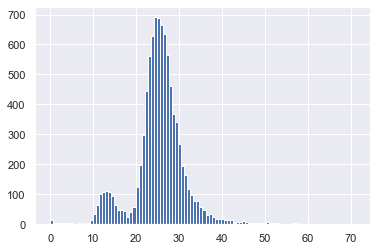

t4-t3


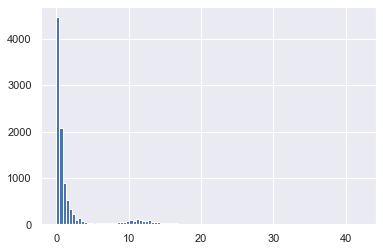

t5-t3


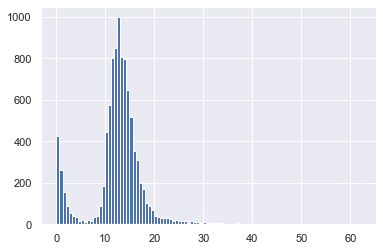

t6-t3


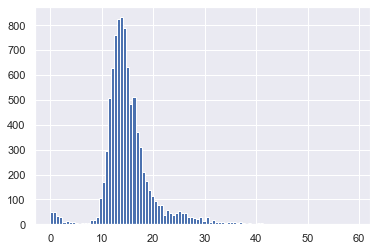

t5-t4


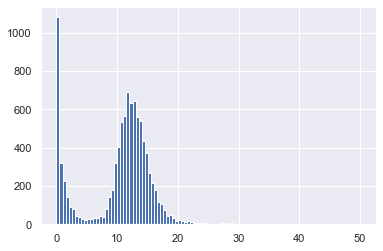

t6-t4


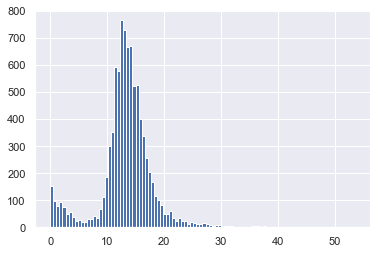

t6-t5


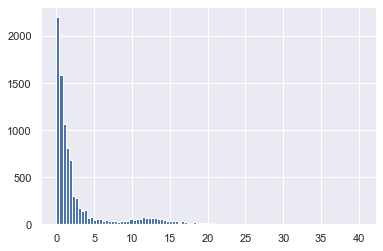

In [210]:
for col in X.columns:
    X[col].hist(bins=100)
    print(col)
    plt.show()

In [ ]:
X

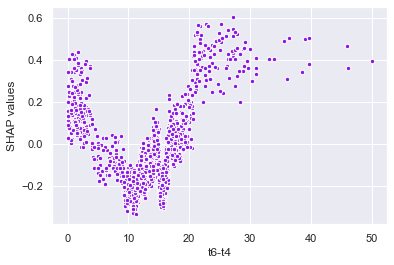

In [227]:
jitter = np.random.uniform(low=-0.1, high=.1, size=(sample.shape[0],))


sns.set_theme()
ax = sns.scatterplot(sample.iloc[:,-2], shap_values[1][:,-2], 
                     alpha=1, s=20, linewidth=1,color='#8b17e3')
ax.set(xlabel='t6-t4', ylabel='SHAP values')
plt.savefig('t6-t4.png', format='png', dpi=800)
#plt.show()


#plt.show()



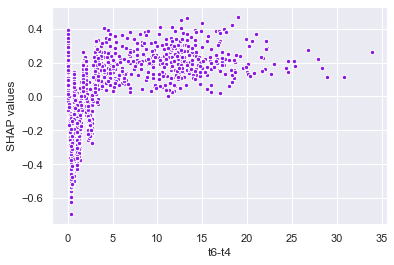

In [203]:
ax = sns.scatterplot(sample.iloc[:,26], shap_values[1][:,26], 
                     alpha=1, s=20, linewidth=1,color='#8b17e3')
ax.set(xlabel='t6-t4', ylabel='SHAP values')
plt.savefig('t6-t4.png', format='png', dpi=800)
#plt.show()



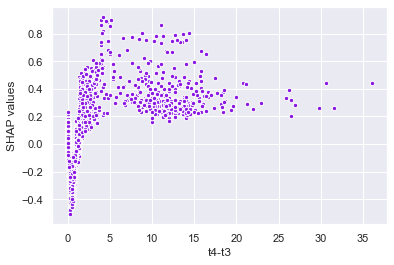

In [204]:

ax = sns.scatterplot(sample.iloc[:,21], shap_values[1][:,21], 
                     alpha=1, s=20, linewidth=1,color='#8b17e3')
ax.set(xlabel='t4-t3', ylabel='SHAP values')
plt.savefig('t4-t3.png', format='png', dpi=800)
#plt.show()



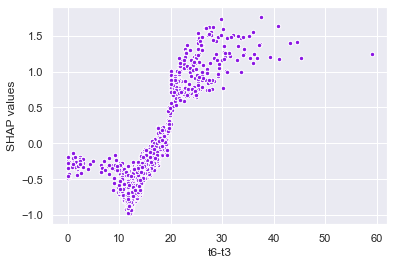

In [186]:

ax = sns.scatterplot(sample.iloc[:,23], shap_values[1][:,23], 
                     alpha=1, s=20, linewidth=1,color='#8b17e3')
ax.set(xlabel='t6-t3', ylabel='SHAP values')
plt.savefig('t6-t3.png', format='png', dpi=800)
#plt.show()


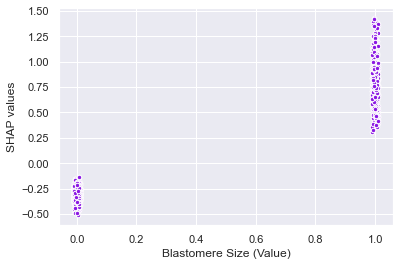

In [187]:

ax = sns.scatterplot(sample.iloc[:,8]+jitter/10, shap_values[1][:,8], 
                     alpha=1, s=20, linewidth=1,color='#8b17e3')
ax.set(xlabel='Blastomere Size (Value)', ylabel='SHAP values')
plt.savefig('Blastomere Size (Value).png', format='png', dpi=800)
#plt.show()



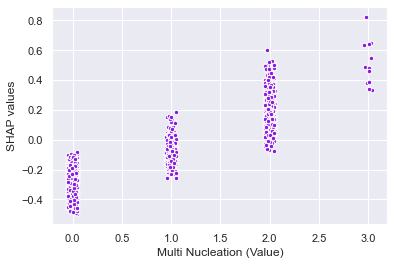

In [188]:

ax = sns.scatterplot(sample.iloc[:,10]+jitter/2, shap_values[1][:,10], 
                     alpha=1, s=20, linewidth=1,color='#8b17e3')
ax.set(xlabel='Multi Nucleation (Value)', ylabel='SHAP values')
plt.savefig('Multi Nucleation (Value).png', format='png', dpi=800)

In [189]:
shap_values[1][:,10].mean()

0.01797650240150072

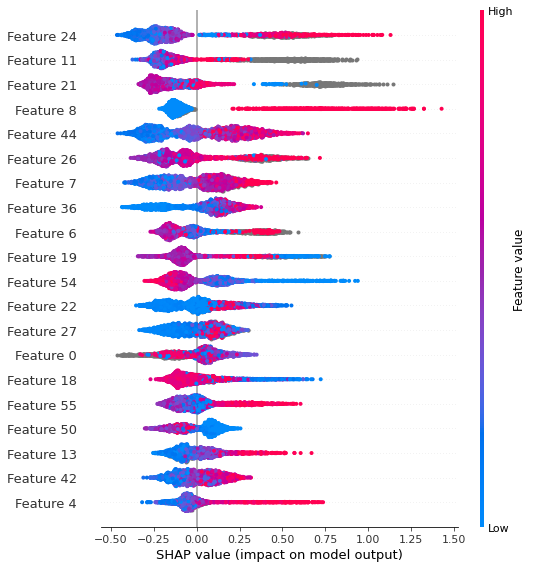

<Figure size 432x288 with 0 Axes>

In [667]:
%matplotlib inline
shap.summary_plot(shap_values[1], sample, plot_type='dot')#.
plt.savefig('summary_plot.png', format='png', dpi=800)

In [1227]:
fig.savefig('myimage.png', format='png', dpi=800)

AttributeError: 'NoneType' object has no attribute 'savefig'

In [85]:
shap.initjs()

In [957]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

IndexError: invalid index to scalar variable.

In [88]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [89]:
import tensorflow_addons as tfa
def printGraph(history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [90]:
def get_model(inpt):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=inpt),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(56, activation='relu'),
        tf.keras.layers.Dropout(0.1),
       
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    return model

In [91]:
get_model(5)

In [92]:
LOSS = tfa.losses.SigmoidFocalCrossEntropy(
    from_logits = False,
    alpha = 0.25,
    gamma = 2.0,
    reduction = tf.keras.losses.Reduction.NONE,
    name = 'sigmoid_focal_crossentropy'
)

In [93]:
opt = tfa.optimizers.AdamW(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,weight_decay=0.001)


In [96]:
X = df.loc[:,:35]#[feats]
y = LabelEncoder().fit_transform(df.loc[:,36])


In [95]:
from fastai import *
from fastai.tabular import *

OSError: [WinError 127] The specified procedure could not be found

In [ ]:
# Analyse our model
learn.model
learn.recorder.plot_losses()

In [97]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
n_folds = 20
avg_acc = 0
kfold = KFold(n_folds)
count = 0
#total_preds = np.zeros(len(df_new[feats]))
confs = []
epochs = 500
for train, test in kfold.split(X, y):
    count+=1
    print('fold: ', count)
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train,  y_test = y[train], y[test]
    smote = SMOTE(sampling_strategy={ 2 : 5076})
    temp, temp1 = smote.fit_resample(X_train.values, y_train)

    X_train, y_train = pd.DataFrame(temp,columns=X_train.columns), temp1
    clf = lightgbm.LGBMClassifier(class_weight={1:2.5})
    clf.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],

         early_stopping_rounds=10)
    
    preds1 = clf.predict_proba(X_test)
    feats_nn = [15,13,5,18,17,10,20,22,24,25,26]
    y_train = OneHotEncoder().fit_transform(np.reshape(y_train,(y_train.shape[0],1))).toarray()
    y_test = OneHotEncoder().fit_transform(np.reshape(y_test,(y_test.shape[0],1))).toarray()
    model = get_model(X_train.shape[1])
    model.compile(optimizer=opt,
              loss=LOSS,
              metrics=['accuracy'])
    #X_train = StandardScaler().fit_transform(X_train)
    #X_test = StandardScaler().fit_transform(X_test)
    
    
    history = model.fit(X_train.values, y_train, epochs=epochs,batch_size=1000,
                    validation_data=(X_test.values, y_test), verbose =False)
    preds2 = model.predict(X_test)
    preds = np.argmax((preds1+preds2)/2, 1)
    #y_test = np.argmax(y_test, 1)
    print(classification_report(np.argmax(y_test, 1), preds))
    
    from sklearn.metrics import confusion_matrix, accuracy_score
    conf = confusion_matrix(np.argmax(y_test, 1),preds)
    print(f'accuracy{count}: ',accuracy_score(np.argmax(y_test, 1),preds))
    confs.append(conf)
    print(conf)
    print(printGraph(history))
    avg_acc+=accuracy_score(np.argmax(y_test, 1), preds)

print('average_accuracy: ', avg_acc/n_folds)

fold:  1


ValueError: The {2} target class is/are not present in the data.

In [ ]:
sns.heatmap(sum(confs),annot=True, cmap=plt.cm.Blues,
            fmt="d");

In [ ]:
sns.heatmap(sum(confs),annot=True, cmap=plt.cm.Blues,
            fmt="d");

In [ ]:
feats_nn = [10,14,4,27,20,28,29,31]

In [ ]:
X_train, X_test,  y_train, y_test = train_test_split(X, OneHotEncoder().fit_transform(np.reshape(y,(y.shape[0],1))).toarray())

In [ ]:
X_train, X_test = StandardScaler().fit_transform(X_train), StandardScaler().fit_transform(X_test)

In [ ]:
X_train, X_test = X_train.values, X_test.values

In [ ]:
import shap
import numpy as np
model = get_model(X_train.shape[1])
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=500,batch_size=1000,
                    validation_data=(X_test, y_test), verbose =False)


# we use the first 100 training examples as our background dataset to integrate over


In [ ]:
printGraph(history)

In [ ]:
preds2 = model.predict(X_test)
preds = np.argmax((preds2+preds2)/2, 1)
#y_test = np.argmax(y_test, 1)
print(classification_report(np.argmax(y_test, 1), preds))

from sklearn.metrics import confusion_matrix, accuracy_score
conf = confusion_matrix(np.argmax(y_test, 1),preds)

In [ ]:
conf

In [ ]:
explainer = shap.DeepExplainer(model, X_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:100])

In [ ]:
shap.initjs()
shap.summary_plot(explainer.expected_value[0], shap_values[0], X_test[:10].values[0])

In [ ]:
shap_values[0].shape

In [ ]:
shap.summary_plot(shap_values[1], X_test[:100])